In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from PIL import Image
import os

In [25]:
#import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [26]:
# For moving all img files from one root dir to another
# source = "Train"
# dest = "Train1"

# label_flood_dir = os.path.join('Labeled','Flooded','image')
# label_nonflood_dir = os.path.join('Labeled','Non-Flooded','image')

# for dire in label_flood_dir,label_nonflood_dir:
#     source_dir = os.path.join(source,dire)
#     dest_dir = os.path.join(dest,dire)
#     for file in os.listdir(source_dir):
#         source_file = os.path.join(source_dir,file)
#         dest_file = os.path.join(dest_dir,file)
#         os.rename(source_file,dest_file)

Should take around 3 minutes to load

In [27]:
h_dim = 1000
v_dim = 750
print("Loading Data from Memory")

root = "Train"
label_flood_dir = os.path.join(root,'Labeled','Flooded','image')
label_nonflood_dir = os.path.join(root,'Labeled','Non-Flooded','image')
flooded_img = []
nonflooded_img = []

for file in os.listdir(label_flood_dir):
    image = Image.open(os.path.join(label_flood_dir, file))
    flooded_img.append(np.array(image.resize((h_dim,v_dim))))
    
for file in os.listdir(label_nonflood_dir):
    image = Image.open(os.path.join(label_nonflood_dir, file))
    nonflooded_img.append(np.array(image.resize((h_dim,v_dim))))
print("Loaded!")

Loading Data from Memory
Loaded!


In [28]:
print(flooded_img[0].shape)

(750, 1000, 3)


In [29]:
print("Flooded Image Shape: {}".format(flooded_img[0].shape))
print("Non_Flooded Image Shape: {}".format(nonflooded_img[0].shape))

Flooded Image Shape: (750, 1000, 3)
Non_Flooded Image Shape: (750, 1000, 3)


In [30]:
data_img = np.vstack((np.array(flooded_img), np.array(nonflooded_img))) / 255.
data_img.shape

(397, 750, 1000, 3)

In [31]:
data_img.max()

1.0

In [32]:
data_img.min()

0.0

In [33]:
np.array(flooded_img).shape

(51, 750, 1000, 3)

In [34]:
import random
test = False

#n is number images from each class (flooded or non flooded)
if test == True:
    n = 20
    #train_idx = np.array([np.arange(7),np.arange(10,17)]).flatten()
    #test_idx = np.array([np.arange(7,10),np.arange(17,20)]).flatten()
else:
    n = min(len(flooded_img),len(nonflooded_img))

'''split data 50 50'''
def train_test_split(n):
    idxs = list(range(n))
    s = int(np.floor(0.8*n)) # number of images for training
    
    train_idx = []
    test_idx = []
    
    #index range to select from (flooded img range, non flooded image range)
    for s_i,e_i in [(0,len(flooded_img)),(len(flooded_img),len(data_img))]:
        
        #print(s_i,e_i,n,s)
        #get all poss indexes for set
        s_idx = list(range(s_i,e_i))
        random.shuffle(s_idx)
        
        train_idx.extend(s_idx[:s])      #first s images are for training
        test_idx.extend(s_idx[s:n])      # next n-s images are for testing. 
        #print(len(train_idx))
    
    train_idx = np.array(train_idx)
    test_idx = np.array(test_idx)
    train_idx.sort()
    test_idx.sort()
    
    train_labels = [1 if x<len(flooded_img) else 0 for x in train_idx]
    test_labels = [1 if x<len(flooded_img) else 0 for x in test_idx]

    print("Training Index: {}".format(train_idx))
    print("Testing Index: {}".format(test_idx))
    return train_idx, test_idx, train_labels, test_labels

train_idx, test_idx, train_labels, test_labels = train_test_split(n)


Training Index: [  0   1   3   4   5   6   7   8   9  10  11  12  14  15  16  17  18  19
  20  21  22  23  25  28  30  31  32  34  35  36  38  39  40  41  42  43
  45  46  49  50  58  82  87  93  99 114 116 118 132 137 139 147 158 164
 170 176 178 179 181 225 230 235 237 268 273 282 286 297 307 314 317 319
 326 331 337 357 369 382 387 389]
Testing Index: [  2  13  24  26  27  29  33  37  44  47  48  71 156 220 243 263 264 292
 294 303 360 365]


In [43]:
# convolutional layer
# x the input 
# shape is dimension of input
def conv_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[-1]]))

    out = tf.nn.conv2d(input=x, filters=weights, strides=[1,1,1,1], padding='SAME')
    out += bias
    return out

# pooling layer
def max_pool(x, k=2):

    out = tf.nn.max_pool(value=x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    return out

# fully connected layer
def fully_connected_layer(x, shape):

    weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    bias = tf.Variable(tf.constant(0.05, shape=[shape[1]]))

    out = tf.matmul(a=x, b=weights)
    out += bias
    return out

# flatten layer
def flatten_layer(x):
    
    size = x.get_shape()[1:4].num_elements()
    out = tf.reshape(x, [-1,size])
    return out, size

# relu
relu = lambda x: tf.nn.relu(features=x)

# softmax
softmax = lambda x: tf.nn.softmax(logits=x)

# batch norm
#batch_norm = lambda x: tf.nn.batch_normalization(x)

In [46]:
def toy_model(x):

    # three convolutional layers with max pool
    shape0 = [5, 5, 3, 3] # filter dim: 5 x 5, 3 input channels, 3 output channels
    conv0 = conv_layer(x, shape0)
    conv0 = max_pool(conv0, k=2)
    #conv0 = batch_norm(conv0)
    #conv0 = relu(conv0)

    shape1 = [5, 5, 3, 1]
    conv1 = conv_layer(conv0, shape1)
    conv1 = max_pool(conv1, k=2)
    #conv1 = batch_norm(conv1)
    #conv1 = relu(conv1)

    shape2 = [5, 5, 1, 1]
    conv2 = conv_layer(conv1, shape2)
    conv2 = max_pool(conv2, k=2)
    #conv2 = batch_norm(conv2)
    #conv2 = relu(conv2)

    # flatten output and put through a fully connected layer
    flat1, size1 = flatten_layer(conv2)
    fc1 = fully_connected_layer(flat1, [size1, 64])
    fc1 = relu(fc1)

    fc2 = fully_connected_layer(fc1, [64, 2])
    out = softmax(fc2)

    return out

In [53]:
def sharpen(p):
    T = 0.5
    pred = p**(1./T)/(p**(1./T) + (1.-p)**(1./T))
    return pred

In [27]:
# define inputs
x = tf.placeholder(tf.float32, [None, v_dim, h_dim, 3])
y = tf.placeholder(tf.float32, [None, 1])
y_train_true = np.array(train_labels).reshape(-1,1)
y_test_true = np.array(test_labels).reshape(-1,1)

# run model with placeholder tensors
pred = toy_model(x)

# sharpen
pred = sharpen(pred)

# define loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y)
cost = tf.reduce_mean(cross_entropy)

# define accuracy
pred_correct = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(pred_correct, tf.float32))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

# initialize variables
init = tf.global_variables_initializer()
training_iters = 20
batch_size = 2#len(train_idx)

Tensor("truediv_4:0", shape=(?, 2), dtype=float32)


In [54]:
# train model
with tf.Session(config=config) as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    num_batches = len(train_idx)//batch_size
    
    for i in range(training_iters):
        
        # Reset metrics
        loss_total = 0
        acc_total = 0
   
        # Run optimization 
        # Calculate batch loss and accuracy
        for batch in range(num_batches):
            batch_x = data_img[train_idx,:,:,:][batch*batch_size:min((batch+1)*batch_size,len(train_idx))]
            batch_y = y_train_true[batch*batch_size:min((batch+1)*batch_size,len(y_train_true))]    

            feed_dict={x: batch_x, y: batch_y}
            opt = sess.run(optimizer, feed_dict=feed_dict)
            loss, acc = sess.run([cost, accuracy], feed_dict=feed_dict)
            loss_total += loss
            acc_total += acc

        # Average metrics
        ave_loss = loss_total/num_batches
        ave_acc = acc_total/num_batches
        
        

        # Calculate accuracy for all test images
        test_acc,valid_loss = sess.run([accuracy,cost],
                                feed_dict={x: data_img[test_idx,:,:,:], y : y_test_true})
        train_loss.append(ave_loss)
        test_loss.append(valid_loss)
        train_accuracy.append(ave_acc)
        test_accuracy.append(test_acc)
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(ave_loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(ave_acc)+ \
                      " ,Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.693235, Training Accuracy= 0.47500 ,Testing Accuracy: 0.00000
Iter 1, Loss= 0.693149, Training Accuracy= 0.55000 ,Testing Accuracy: 0.59091
Iter 2, Loss= 0.693147, Training Accuracy= 0.48750 ,Testing Accuracy: 0.95455
Iter 3, Loss= 0.693147, Training Accuracy= 0.55000 ,Testing Accuracy: 0.95455
Iter 4, Loss= 0.693147, Training Accuracy= 0.46250 ,Testing Accuracy: 0.95455
Iter 5, Loss= 0.693147, Training Accuracy= 0.51250 ,Testing Accuracy: 0.72727
Iter 6, Loss= 0.693147, Training Accuracy= 0.50000 ,Testing Accuracy: 0.68182
Iter 7, Loss= 0.693147, Training Accuracy= 0.45000 ,Testing Accuracy: 0.59091
Iter 8, Loss= 0.693147, Training Accuracy= 0.46250 ,Testing Accuracy: 0.59091
Iter 9, Loss= 0.693147, Training Accuracy= 0.48750 ,Testing Accuracy: 0.63636
Iter 10, Loss= 0.693147, Training Accuracy= 0.47500 ,Testing Accuracy: 0.50000
Iter 11, Loss= 0.693147, Training Accuracy= 0.42500 ,Testing Accuracy: 0.45455
Iter 12, Loss= 0.693147, Training Accuracy= 0.48750 ,Testing A

In [55]:
ave_loss

0.6931473106145859

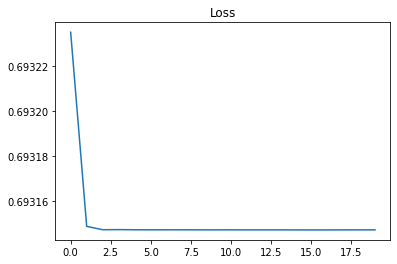

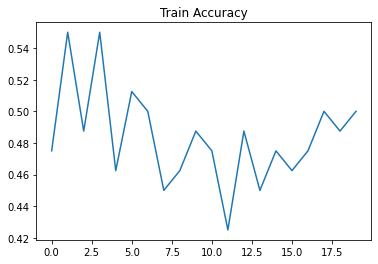

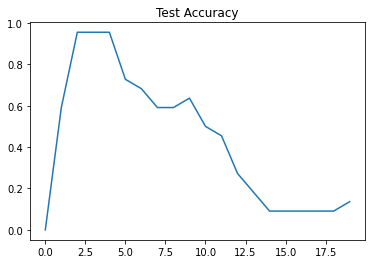

In [57]:
for title, data in {"Loss":train_loss,"Train Accuracy": train_accuracy, "Test Accuracy": test_accuracy}.items():
    plt.plot(data)
    plt.title(title)
    plt.show()